In [1]:
import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.metrics import rmse
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score


In [2]:
df = utils.load_data()

df.head(10)

,FFED,US_PERSONAL_SPENDING_PCE,US_CPI,US_TB_YIELD_10YRS,US_UNEMPLOYMENT_RATE
DATE,,,,,
1962-01-31,2.022727,353.200012,NaN,4.083182,5.800000
1962-02-28,2.388889,353.200012,30.040001,4.039444,5.800000
1962-03-31,2.852273,354.045441,30.062273,3.930454,5.545455
1962-04-30,2.800000,357.399994,30.139999,3.843000,5.600000
1962-05-31,2.431818,359.063629,30.186363,3.873636,5.595455
1962-06-30,2.702381,362.000000,30.224285,3.909048,5.500000
1962-07-31,2.690476,360.399994,30.225714,4.014286,5.500000
1962-08-31,2.945652,361.530426,30.214783,3.975652,5.426087
1962-09-30,2.894737,362.899994,30.248421,3.978947,5.700000


In [3]:

# Create a TimeSeries object
ts = TimeSeries.from_dataframe(df, value_cols=['US_TB_YIELD_10YRS']) #.add_holidays("US")

# Create covariates
covariates = df.drop(columns=['US_TB_YIELD_10YRS'])
covariates = TimeSeries.from_dataframe(covariates)

In [4]:
assert len(ts.gaps()) == 0

# Naive Model

  0%|          | 0/104 [00:00<?, ?it/s]

rmse = 0.21
mape = 7.40%
r2 = 0.96


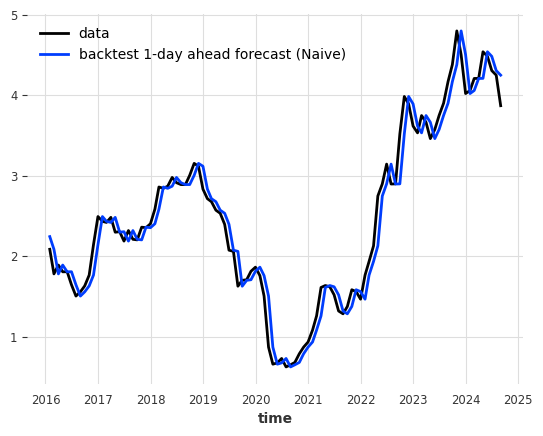

In [5]:

# Create a Naive Seasonal model
model = NaiveSeasonal(K=1)
model.fit(ts)


hfc_params = {
    "series": ts,
    "start": pd.Timestamp("2016-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
}
historical_fcast_theta = model.historical_forecasts(last_points_only=True, **hfc_params)

ts.drop_before(pd.Timestamp("2016-01-01")).plot(label="data")
historical_fcast_theta.plot(label="backtest 1-day ahead forecast (Naive)")
print(f"rmse = {rmse(ts, historical_fcast_theta):.2f}")
print(f"mape = {mape(ts, historical_fcast_theta):.2f}%")
print(f"r2 = {r2_score(ts, historical_fcast_theta):.2f}")



# Pytorch-based models

## RNN

In [6]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
    Diff
)

log_transformer = InvertibleMapper(
    fn=np.log1p, inverse_fn=np.expm1, name="log1p"
)
scaler = Scaler()
filler = MissingValuesFiller()
differentiator = Diff(dropna=True)
pipeline = Pipeline([filler, log_transformer, scaler, differentiator])
covariates_pipeline = Pipeline([filler, log_transformer, scaler, differentiator])


covariates_scaled = covariates_pipeline.fit_transform(covariates)
ts_scaled = pipeline.fit_transform(ts)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

In [38]:
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=1e-6,
    mode="min"
)

model = BlockRNNModel(
    random_state=0,
    model_name="block_rnn",
    log_tensorboard=True,
    save_checkpoints=True,
    force_reset=True,
    show_warnings=True,
    pl_trainer_kwargs={"callbacks": [early_stopper]},

    model="GRU", # The type of RNN to use. One of: “LSTM”, “GRU” or “RNN”
    input_chunk_length=20, # Number of time steps in the past to take as a model input (per chunk). 
    output_chunk_length=1, # Number of time steps predicted at once (per chunk) by the internal model
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    dropout=0, # Fraction of neurons afected by Dropout.
    hidden_dim=20, # Size for feature maps for each hidden RNN layer ()
    activation="TanH", # The name of a torch.nn activation function to be applied between the layers of the fully connected network. Default: “ReLU”.

    batch_size=32,
    n_rnn_layers=2, # Number of layers in the RNN module.

    lr_scheduler_cls=CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 20, "eta_min": 1e-4}, # The maximum number of epochs in the cosine annealing scheduler
    use_reversible_instance_norm = True,
    # likelihood=GaussianLikelihood(), # https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#darts.utils.likelihood_models.Likelihood
    # hidden_fc_sizes=[20, 20], # Size of the fully connected layers between the RNN and the output layer
)


model.fit(
    train_ts_scaled, 
    val_series=val_ts_scaled,
    verbose=True,
    past_covariates=train_covariates_scaled,
    val_past_covariates=val_covariates_scaled,
)


# model = BlockRNNModel.load_from_checkpoint("block_rnn")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rin             | RINorm           | 2      | train
6 | rnn             | GRU              | 4.1 K  | train
7 | fc              | Sequential       | 21     | train
-------------------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=20, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0, activation=TanH, random_state=0, model_name=block_rnn, log_tensorboard=True, save_checkpoints=True, force_reset=True, show_warnings=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x36104ae50>]}, input_chunk_length=20, output_chunk_length=1, n_epochs=100, optimizer_kwargs={'lr': 0.001}, batch_size=32, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, lr_scheduler_kwargs={'T_max': 20, 'eta_min': 0.0001}, use_reversible_instance_norm=True)

In [42]:
hfc_params = {
    "series": ts_scaled,
    "past_covariates": covariates_scaled,
    "start": pd.Timestamp("2016-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
    "retrain": False
}

historical_fcast_block_rnn = model.historical_forecasts(last_points_only=True, **hfc_params)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

rmse = 0.60
mape = 27.32%
r2 = 0.68


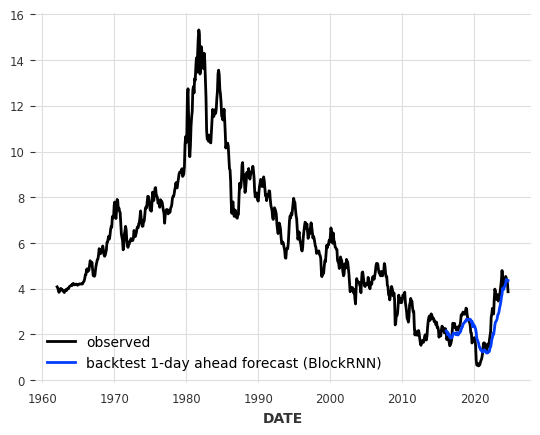

In [43]:


historical_fcast_block_rnn = train_ts_scaled.append(historical_fcast_block_rnn)
historical_fcast_block_rnn = pipeline.inverse_transform(historical_fcast_block_rnn, partial=True)
historical_fcast_block_rnn = historical_fcast_block_rnn.drop_before(pd.Timestamp("2016-01-01"))

ts.plot(label="observed")
historical_fcast_block_rnn.plot(label="backtest 1-day ahead forecast (BlockRNN)")

print(f"rmse = {rmse(ts, historical_fcast_block_rnn):.2f}")
print(f"mape = {mape(ts, historical_fcast_block_rnn):.2f}%")
print(f"r2 = {r2_score(ts, historical_fcast_block_rnn):.2f}")